In [ ]:
import adi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.graphics.gofplots import  qqplot

Uri = "ip:192.168.1.34"
sdr  = adi.Pluto(Uri)

In [ ]:
def complexExp(N,Fc,Fs):
    # N : Number of samples to transmit at once
    # Fc: Carrier frequency in Hz
    # Fs: Sampling frequency in Hz
    if Fs < 2*Fc:
        raise ValueError(
            "Error: Fs must be at least 2 time Fc"
        )
    Tsamp  = 1/Fs;
    n      = np.arange(N)
    signal = 1.0*np.exp(1j*2.0*np.pi*Fc*n*Tsamp) 
    return signal

nSamples     = 2**20
samplingRate = 2.0e6
frec         = samplingRate/8
txSignalExp  = complexExp(nSamples,frec,samplingRate)

def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

plotSignal(txSignalExp[0:400])

In [ ]:
def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

plotSpect(txSignalExp,samplingRate)

#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = Uri
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter
SamplingRate     = samplingRate  # Sample rate RX and TX paths[Samples/Sec]

TxLOFreq         = 938e6         # Carrier frequency of TX path [Hz]
TxAtten          = -70           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
RxBufferSize     = nSamples      # Depend on the length of the transmit signal. Maximum tx buffer size 2**24[samples]
tx_cyclic_buffer = False

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20       # Rx Buffer size. Maximun value 2**28 [Samples]

sdr.loopback = Loopback
sdr.sample_rate = samplingRate  # Sample rate RX and TX paths[Samples/Sec]
sdr.tx_rf_bandwidth = int(TxRfBw)  # Bandwidth of front-end analog filter of TX path [Hz]
sdr.rx_rf_bandwidth = int(RxRfBw)  # Bandwidth of front-end analog filter of RX path [Hz] 
sdr.tx_hardwaregain_chan0   = TxAtten # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
sdr.rx_hardwaregain_chan0   = RxHardwareGain   # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
sdr.gain_control_mode_chan0 = GainControlModes # Receive path AGC Options: slow_attack, fast_attack, manual
sdr.tx_lo = int(TxLOFreq)# Carrier frequency of TX path [Hz]
sdr.rx_lo = int(RxLOFreq) # Carrier frequency of RX path [Hz]
sdr.rx_buffer_size   = RxBufferSize
sdr.tx_cyclic_buffer = tx_cyclic_buffer
#sdr._ctrl.context.set_timeout(0) # <- disable timeout if you want to use large buffer size


#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignalExp*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs


#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()


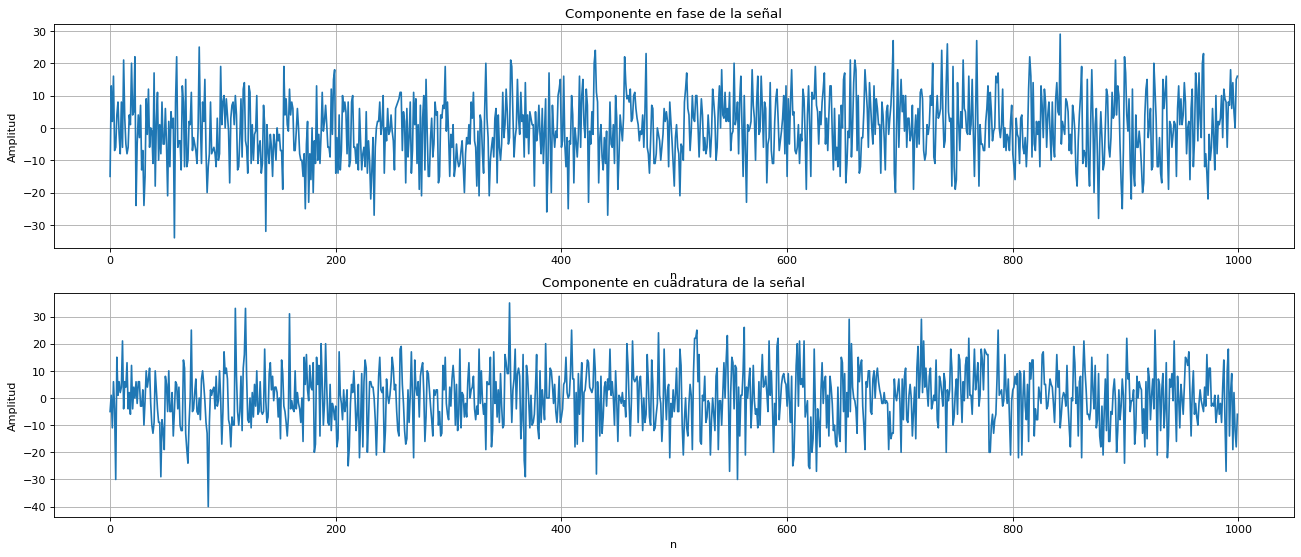

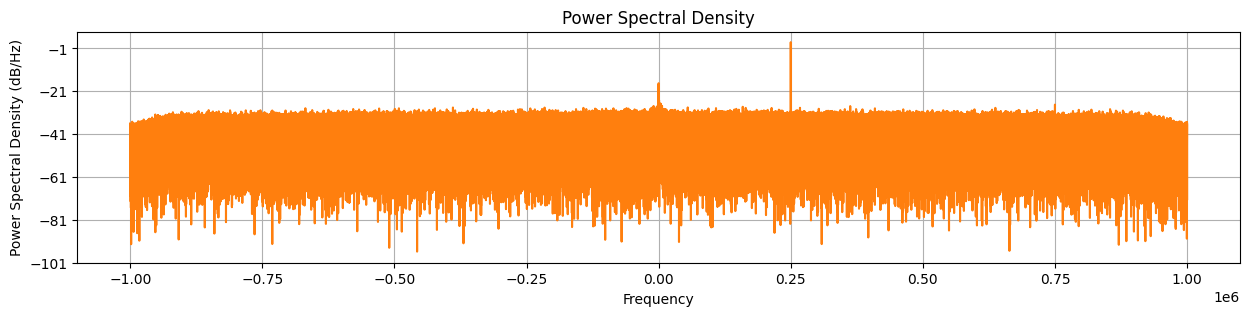

In [159]:
plotSignal(rxSignal[0:1000])
plotSpect(rxSignal,samplingRate)

-0.007782936096191406 0.0006351470947265625
110.2853483995992 110.46940763186649


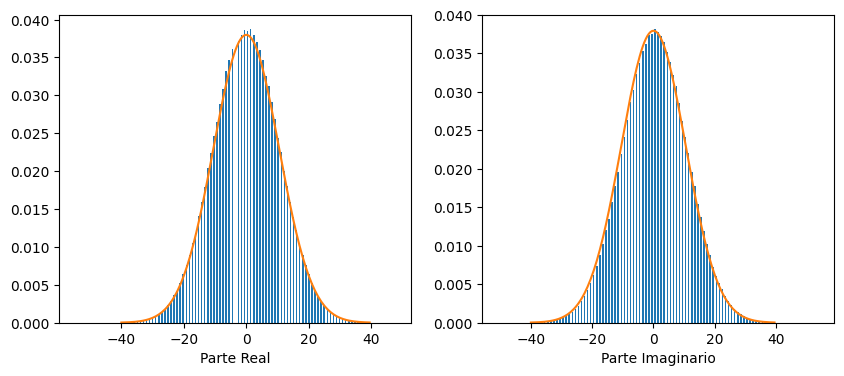

In [147]:
#1) Obtener la media y la varianza.

#   MEDIA   #

# rxSignal = sdr.rx()
real = np.real(rxSignal);
imag = np.imag(rxSignal);
print(np.mean(real),np.mean(imag))

mediaReal = np.mean(real)
mediaImag = np.mean(imag)

#   Varianza    #
print(np.var(real),np.var(imag))
varianzaReal = np.var(real);
desviacionReal = np.std(real)

varianzaImag = np.var(imag);
desviacionImag = np.std(imag)

#2,3 y 4) Realizar un histograma, Normalizar el histograma para que el area encerrada sea igual a 1
# y Superponer el histograma normalizado con una función de densidad de probabilidad (PDF) gaussiana teórica

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.xlabel("Parte Real")
plt.hist(real, rwidth=.5, bins= 105, density=True)

X = np.arange(-40,40,step = 0.5)
gauss_real = (1/(np.sqrt(2*np.pi*varianzaReal)))*np.exp(-(pow((X-mediaReal),2)/(2*varianzaReal)))
plt.plot(X,gauss_real)


plt.subplot(1,2,2)
plt.xlabel("Parte Imaginario")

plt.hist(imag,rwidth=.5,bins= 105,density=True)

X = np.arange(-40,40,step = 0.5)
gauss_imag = (1/(np.sqrt(2*np.pi*varianzaImag)))*np.exp(-(pow((X-mediaImag),2)/(2*varianzaImag))) 
plt.plot(X,gauss_imag)

plt.show()



In [ ]:
#Analizar la gaussianidad mediante un gráfico Q-Q haciendo uso de la función propia de python "qqplot"
qqplot(real,line = 's')
plt.title("Parte Real")
qqplot(imag,line = 's')
plt.title("Parte Imaginaria")
plt.show()

Señal:  (0.40124648273771585-2.049702286488846j) RX:  (-0.007782936096191406+0.0006351470947265625j)


C:\Users\Gaston\AppData\Local\Temp\ipykernel_7940\2076347337.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  señal1 = np.random.normal(loc = np.mean(rxSignal), scale = np.std(rxSignal), size = 300)
C:\Users\Gaston\AppData\Local\Temp\ipykernel_7940\2076347337.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  señal2 = np.random.normal(loc = np.mean(rxSignal), scale = np.std(rxSignal), size = 300)
C:\Users\Gaston\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Gaston\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


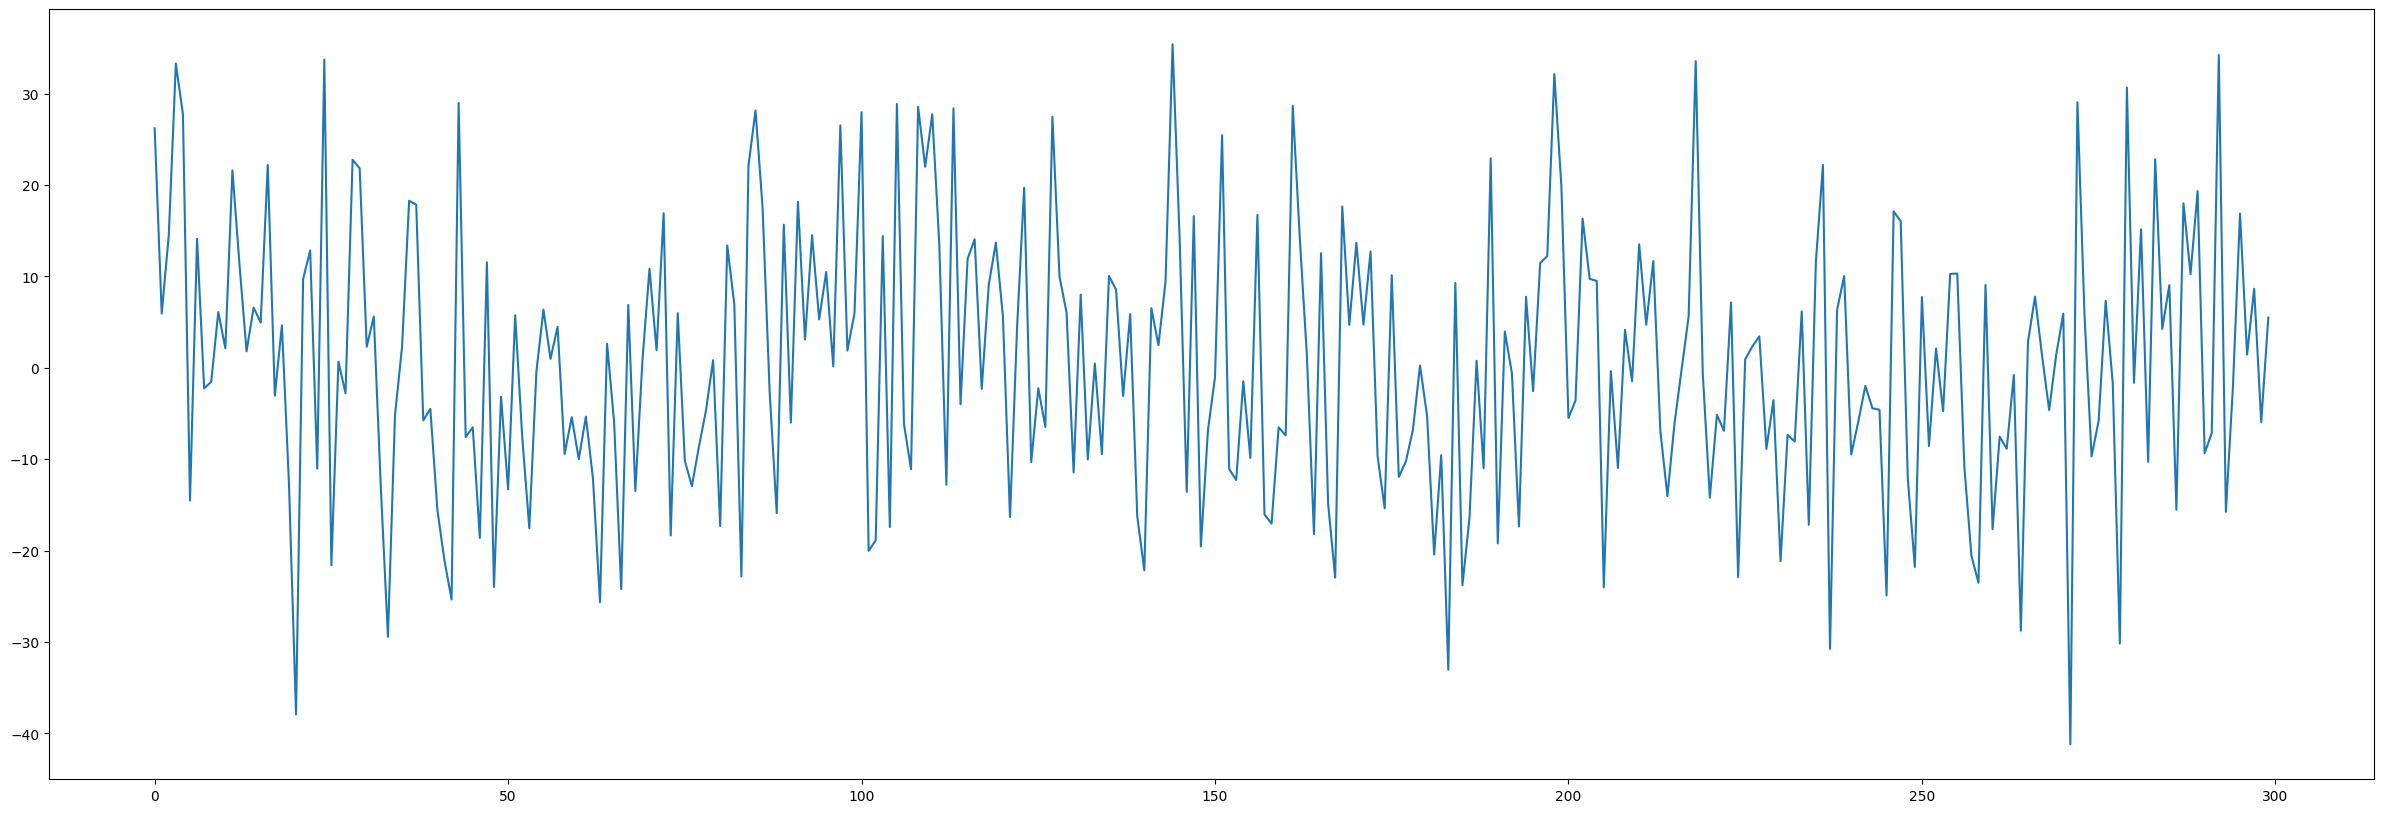

In [165]:
#Variable Gaussiana Compleja
np.random.seed(0)
plt.figure(figsize=(30,10))
señal1 = np.random.normal(loc = np.mean(rxSignal), scale = np.std(rxSignal), size = 300)
señal2 = np.random.normal(loc = np.mean(rxSignal), scale = np.std(rxSignal), size = 300)
señal = señal1+1j*señal2
print("Señal: ",np.mean(señal),"RX: ",np.mean(rxSignal))
plt.plot(señal,scalex = True)

Ejecutar al Final

In [ ]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

# Destroy radio object
# del(sdr)